Chessboard Convolutional Neural Network classifier
---
**[Link to Github source code](https://github.com/Elucidation/tensorflow_chessbot)**

In the previous notebook we did a 1-layer simple softmax regression classifier, which had ~99% accuracy since we were testing on a cordoned off portion of the entire dataset. This worked well for a majority of reddit posts, but whenever we had a screenshot of a board or piece set that was sufficiently different we'd end up mistaking pawns for bishops etc. We're aiming for some domain adaptation here, where our collected dataset consists of around 9000 tiles from several themes within lichess.org, chess.com and two fen diagram generator sites. But we'd like it to apply to chessboard screenshots of themes or sites we haven't trained for.

As a first step, we'll build a Convolutional Neural Network (CNN) and train it on the same dataset, taking advantage of the fact the spatial information within a tile can provide further insight.

In [1]:
# Init and helper functions
import tensorflow as tf
import numpy as np
import PIL
import urllib, cStringIO
import glob
from IPython.core.display import Markdown
from IPython.display import Image, display

import helper_functions as hf
import tensorflow_chessbot

np.set_printoptions(precision=2, suppress=True)

Let's load the tiles in for the training and test dataset, and then split them in a 90/10 ratio

In [2]:
# All tiles with pieces in random organizations
all_paths = np.array(glob.glob("tiles/train_tiles_C/*/*.png")) # TODO : (set labels correctly)

# Shuffle order of paths so when we split the train/test sets the order of files doesn't affect it
np.random.shuffle(all_paths)

ratio = 0.9 # training / testing ratio
divider = int(len(all_paths) * ratio)
train_paths = all_paths[:divider]
test_paths = all_paths[divider:]

# Training dataset
# Generated by programmatic screenshots of lichess.org/editor/<FEN-string>
print "Loading %d Training tiles" % train_paths.size
train_images, train_labels = hf.loadFENtiles(train_paths) # Load from generated set

# Test dataset, taken from screenshots of the starting position
print "Loading %d Training tiles" % test_paths.size
test_images, test_labels = hf.loadFENtiles(test_paths) # Load from generated set

train_dataset = hf.DataSet(train_images, train_labels, dtype=tf.float32)
test_dataset = hf.DataSet(test_images, test_labels, dtype=tf.float32)

Loading 8294 Training tiles
. . . . . . . . . Done
Loading 922 Training tiles
. Done


Looks good. Now that we've loaded the data, let's build up a deep CNN classifier based off of [this beginner tutorial](https://www.tensorflow.org/versions/v0.6.0/tutorials/mnist/pros/index.html) on tensorflow.

In [3]:
print "Setting up CNN..."
def weight_variable(shape, name=""):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name=""):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x, name=""):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)

x = tf.placeholder(tf.float32, [None, 32*32])

# First layer : 32 features
W_conv1 = weight_variable([5, 5, 1, 32], name='W1')
b_conv1 = bias_variable([32], name='B1')

x_image = tf.reshape(x, [-1,32,32,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, name='Conv1')
h_pool1 = max_pool_2x2(h_conv1, name='Pool1')

# Second convolutional layer : 64 features
W_conv2 = weight_variable([5, 5, 32, 64], name='W2')
b_conv2 = bias_variable([64], name='B2')

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='Conv2')
h_pool2 = max_pool_2x2(h_conv2, name='Pool2')

# Densely connected layer : 1024 neurons, image size now 8x8
W_fc1 = weight_variable([8 * 8 * 64, 1024], name='W3')
b_fc1 = bias_variable([1024], name='B3')

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64], name='Pool3')
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, 'MatMult3')

# Dropout
keep_prob = tf.placeholder("float", name='KeepProb')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name='Drop4')

# Readout layer : softmax, 13 features
W_fc2 = weight_variable([1024, 13], name='W5')
b_fc2 = bias_variable([13], name='B5')

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='Ypredict')

# # Old single layer regression classifier
# W = tf.Variable(tf.zeros([32*32, 13]))
# b = tf.Variable(tf.zeros([13]))
# y = tf.nn.softmax(tf.matmul(x, W) + b)

# Ground truth labels if exist 
y_ = tf.placeholder(tf.float32, [None, 13], name='Ytruth')

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv), name='CrossEntropy')

# train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1), name='CorrectPrediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), name='Accuracy')

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Start Interactive session for rest of notebook (else we'd want to close session)
sess = tf.InteractiveSession()

# Training vs loading existing model
do_training = False

# Number of steps
N = 10000

if do_training:
    #Initialize session
    sess.run(tf.initialize_all_variables())
    
    # Training
    print "Training for %d steps..." % N
    for i in range(N):
        # Get next batch for training
        batch_xs, batch_ys = train_dataset.next_batch(100)

        # Print out progress to screen
        if ((i+1) % 100) == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x:batch_xs, y_: batch_ys, keep_prob: 1.0})
            print "\n\t%d/%d, training accuracy %g" % (i+1, N, train_accuracy),
        elif ((i+1) % 10) == 0:
            print '.',

        # Train model with batch
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

    print "Finished training."

    # Save model checkpoint
    save_path = saver.save(sess, "saved_models/model_%d.ckpt" % N)
    print "Model saved in file: ", save_path

else:
    # Restore model from checkpoint
    model_name = "saved_models/model_%d.ckpt" % N
    print "Loading model '%s'" % model_name
    saver.restore(sess, model_name)
    print "Model restored."
    
# Testing
print "Accuracy: %g\n" % accuracy.eval(feed_dict={x: test_dataset.images,
                                                  y_: test_dataset.labels,
                                                  keep_prob: 1.0})


Setting up CNN...
Training for 10000 steps...
. . . . . . . . . 
	100/10000, training accuracy 0.97 . . . . . . . . . 
	200/10000, training accuracy 0.98 . . . . . . . . . 
	300/10000, training accuracy 0.99 . . . . . . . . . 
	400/10000, training accuracy 0.97 . . . . . . . . . 
	500/10000, training accuracy 1 . . . . . . . . . 
	600/10000, training accuracy 0.98 . . . . . . . . . 
	700/10000, training accuracy 0.99 . . . . . . . . . 
	800/10000, training accuracy 1 . . . . . . . . . 
	900/10000, training accuracy 0.99 . . . . . . . . . 
	1000/10000, training accuracy 0.99 . . . . . . . . . 
	1100/10000, training accuracy 1 . . . . . . . . . 
	1200/10000, training accuracy 0.99 . . . . . . . . . 
	1300/10000, training accuracy 1 . . . . . . . . . 
	1400/10000, training accuracy 1 . . . . . . . . . 
	1500/10000, training accuracy 1 . . . . . . . . . 
	1600/10000, training accuracy 1 . . . . . . . . . 
	1700/10000, training accuracy 1 . . . . . . . . . 
	1800/10000, training accuracy 1 

Let's have a look at the failure cases to get a sense of any mistakes

In [4]:
mistakes = tf.where(~correct_prediction)
mistake_indices = sess.run(mistakes, feed_dict={x: test_dataset.images,
                                                y_: test_dataset.labels,
                                               keep_prob: 1.0}).flatten()

guess_prob, guessed = sess.run([y_conv, tf.argmax(y_conv,1)], feed_dict={x: test_dataset.images, keep_prob: 1.0})


if mistake_indices.size > 0:
    print "%d mistakes:" % mistake_indices.size
    for idx in np.random.choice(mistake_indices, 5, replace=False):
        a,b = test_dataset.labels[idx], guessed[idx]
        print "---"
        print "\t#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
        print "Actual:",a
        print " Guess:",guess_prob[idx,:]
        hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))
else:
    print "%d mistakes" % mistake_indices.size

0 mistakes


It looks like it's been learning that pieces have black borders, and since this pieceSet didn't, and it was a small part of the training set, it just fails and thinks we're looking at blank squares, *more training data!* 
From the label probabilities, it did a reasonable job of thinking the pieces were white, and their second best guesses tended to be close to the right answer, the blank spaces just won out.

Also, lets look at several random selections, including successes.

#619 | Actual: ' ', Guessed: ' '


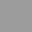

#526 | Actual: 'b', Guessed: 'b'


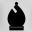

#133 | Actual: 'P', Guessed: 'P'


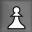

#165 | Actual: 'N', Guessed: 'N'


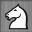

#712 | Actual: 'R', Guessed: 'R'


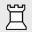

In [5]:
for idx in np.random.choice(test_dataset.num_examples,5,replace=False):
    a,b = test_dataset.labels[idx], guessed[idx]
    print "#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
    hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))

# Predict from image url

Let's wrap up predictions into a single function call from a URL, and test it on a few reddit posts.

In [28]:
def getPrediction(img):
    """Run trained neural network on tiles generated from image"""
    
    # Convert to grayscale numpy array
    img_arr = np.asarray(img.convert("L"), dtype=np.float32)
    
    # Use computer vision to get the tiles
    tiles = tensorflow_chessbot.getTiles(img_arr)
    if tiles is None or len(tiles) == 0:
        print "Couldn't parse chessboard"
        return None, 0.0
    
    # Reshape into Nx1024 rows of input data, format used by neural network
    validation_set = np.swapaxes(np.reshape(tiles, [32*32, 64]),0,1)

    # Run neural network on data
    guess_prob, guessed = sess.run([y_conv, tf.argmax(y_conv,1)], feed_dict={x: validation_set, keep_prob: 1.0})
    
    # Prediction bounds
    a = np.array(map(lambda x: x[0][x[1]], zip(guess_prob, guessed)))
    print "Certainty range [%g - %g], Avg: %g" % (a.min(), a.max(), a.mean())
    
    # Convert guess into FEN string
    # guessed is tiles A1-H8 rank-order, so to make a FEN we just need to flip the files from 1-8 to 8-1
    pieceNames = map(lambda k: '1' if k == 0 else hf.labelIndex2Name(k), guessed) # exchange ' ' for '1' for FEN
    fen = '/'.join([''.join(pieceNames[i*8:(i+1)*8]) for i in reversed(range(8))])
    return fen, a.prod()

def makePrediction(image_url):
    """Given image url to a chessboard image, display a visualization of FEN and link to a lichess analysis
       Return minimum certainty for prediction."""
    # Load image from url and display
    success = True
    try:
        img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url).read()))
    except IOError, e:
        success = False
    if not success:
        try:
            img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url+'.png').read()))
            success = True
        except IOError, e:
            success = False
    if not success:
        try:
            img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url+'.jpg').read()))
            success = True
        except IOError, e:
            success = False
    if not success:
        try:
            img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url+'.gif').read()))
            success = True
        except IOError, e:
            success = False

    if not success:
        print "Couldn't load image url: %s" % image_url
        return 0.0 # certainty
    
    print "Image on which to make prediction: %s" % image_url
    ratio = 250.0 / img.size[1]
    hf.display_image(img.resize([int(img.size[0] * ratio), 250], PIL.Image.ADAPTIVE))
    
    # Make prediction
    fen, certainty = getPrediction(img)
    if fen:
        display(Markdown("Prediction: [Lichess analysis](https://lichess.org/analysis/%s)" % hf.shortenFEN(fen)))
        display(Image(url='http://www.fen-to-image.com/image/30/%s' % fen))
        print "FEN: %s" % hf.shortenFEN(fen)
    return certainty


## Make Predictions

All the boilerplate is done, the model is trained, it's time. I chose the first post I saw on reddit.com/chess with a chessboard (something our CV algorithm can do also): https://www.reddit.com/r/chess/comments/45inab/moderate_black_to_play_and_win/ with an image url of http://i.imgur.com/x6lLQQK.png

And awaayyy we gooo...

Image on which to make prediction: http://i.imgur.com/x6lLQQK.png


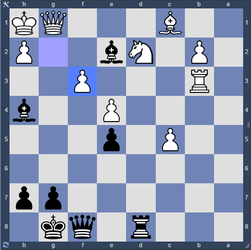

Certainty range [0.999977 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/KQ3B2/P2bN1P1/2P3R1/b2P4/3p1P2/8/pp6/1kq1r3)

FEN: KQ3B2/P2bN1P1/2P3R1/b2P4/3p1P2/8/pp6/1kq1r3


0.99977851

In [29]:
makePrediction('http://i.imgur.com/x6lLQQK.png')

Fantastic, a perfect match! It was able to handle the highlighting on the pawn movement from G2 to F3 also. 

Now just for fun, let's try an image that is from a chessboard we've never seen before! Here's another on reddit: https://www.reddit.com/r/chess/comments/45c8ty/is_this_position_starting_move_36_a_win_for_white/

Image on which to make prediction: http://i.imgur.com/r2r43xA.png


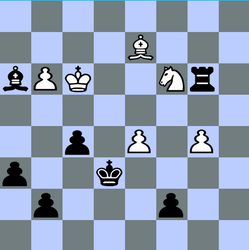

Certainty range [0.645451 - 1], Avg: 0.980475


Prediction: [Lichess analysis](https://lichess.org/analysis/8/4B3/bBK2Nr1/8/2b1B1B1/p2k4/1p3p2/8)

FEN: 8/4B3/bBK2Nr1/8/2b1B1B1/p2k4/1p3p2/8


0.22809464

In [30]:
makePrediction('http://i.imgur.com/r2r43xA.png')

Hah, it thought some of the pawns were bishops. But it predicted all the other pieces and empty squares correctly despite being a chessboard screenshot from a site we haven't collected data on! This is pretty great, let's look at a few more screenshots taken lichess. Here's https://www.reddit.com/r/chess/comments/44q2n6/tactic_from_a_game_i_just_played_white_to_move/

Image on which to make prediction: http://i.imgur.com/gSFbM1d.png


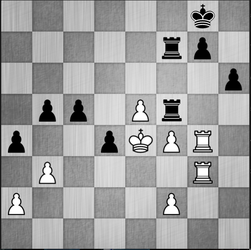

Certainty range [0.999988 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/6k1/5rp1/7p/1pp1Pr2/p2pKPR1/1P4R1/P4P2/8)

FEN: 6k1/5rp1/7p/1pp1Pr2/p2pKPR1/1P4R1/P4P2/8


0.99985528

In [31]:
makePrediction('http://i.imgur.com/gSFbM1d.png')

Yep, it looks like it does well when the validation data is similar to what we trained for, who would have thought. When the validation images are based off of what the model trains, it'll do great, but if we use images from chess boards we haven't trained on, we'll see lots of mistakes. Mistakes are fun, lets see some.

Image on which to make prediction: http://imgur.com/oXpMSQI.png


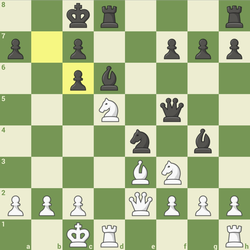

Certainty range [0.998874 - 1], Avg: 0.99992


Prediction: [Lichess analysis](https://lichess.org/analysis/2kr3r/p1p2ppp/2pb4/3N1q2/4n1b1/4BN2/PPP1QPPP/2KR3R)

FEN: 2kr3r/p1p2ppp/2pb4/3N1q2/4n1b1/4BN2/PPP1QPPP/2KR3R


0.99487221

In [32]:
makePrediction('http://imgur.com/oXpMSQI.png')

Image on which to make prediction: http://imgur.com/qk5xa6q.png


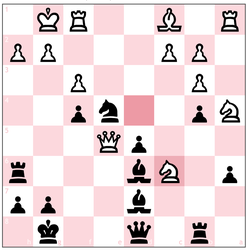

Certainty range [0.527064 - 1], Avg: 0.990506


Prediction: [Lichess analysis](https://lichess.org/analysis/1KR2B1R/PP3PP1/2P3P1/2pn2pn/3Qp3/r3bB1p/pp2b3/1k2q1r1)

FEN: 1KR2B1R/PP3PP1/2P3P1/2pn2pn/3Qp3/r3bB1p/pp2b3/1k2q1r1


0.45862412

In [33]:
makePrediction('http://imgur.com/qk5xa6q.png')

Image on which to make prediction: http://imgur.com/u4zF5Hj.png


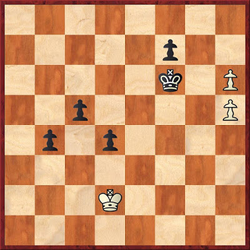

Certainty range [0.999545 - 1], Avg: 0.999977


Prediction: [Lichess analysis](https://lichess.org/analysis/8/5p2/5k1P/2p4P/1p1p4/8/3K4/8)

FEN: 8/5p2/5k1P/2p4P/1p1p4/8/3K4/8


0.99854553

In [34]:
makePrediction('http://imgur.com/u4zF5Hj.png')

Image on which to make prediction: http://imgur.com/CW675pw.png


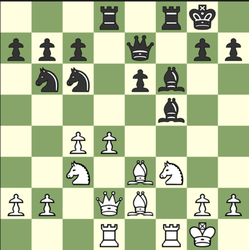

Certainty range [0.929552 - 1], Avg: 0.998573


Prediction: [Lichess analysis](https://lichess.org/analysis/3r1rk1/ppp1q1pp/1nn1pb2/5b2/2PP4/2N1BN2/PP1QB1PP/3R1RK1)

FEN: 3r1rk1/ppp1q1pp/1nn1pb2/5b2/2PP4/2N1BN2/PP1QB1PP/3R1RK1


0.91016573

In [35]:
makePrediction('http://imgur.com/CW675pw.png')

Image on which to make prediction: https://i.ytimg.com/vi/pG1Uhw3pO8o/hqdefault.jpg


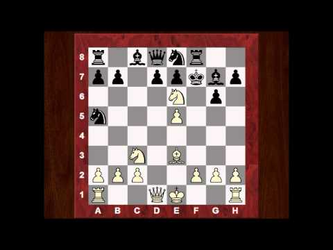

Certainty range [0.983912 - 1], Avg: 0.999481


Prediction: [Lichess analysis](https://lichess.org/analysis/r1bqnr2/pp1ppkbp/4N1p1/n3P3/8/2N1B3/PPP2PPP/R2QK2R)

FEN: r1bqnr2/pp1ppkbp/4N1p1/n3P3/8/2N1B3/PPP2PPP/R2QK2R


0.96714765

In [36]:
makePrediction('https://i.ytimg.com/vi/pG1Uhw3pO8o/hqdefault.jpg')

Image on which to make prediction: http://www.caissa.com/chess-openings/img/siciliandefense1.gif


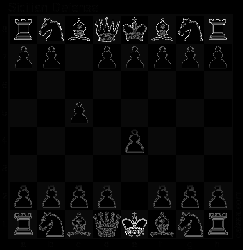

Certainty range [0.554627 - 1], Avg: 0.970189


Prediction: [Lichess analysis](https://lichess.org/analysis/rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PBPB1BPB/RNBQKBNR)

FEN: rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PBPB1BPB/RNBQKBNR


0.082962133

In [37]:
makePrediction('http://www.caissa.com/chess-openings/img/siciliandefense1.gif')

Image on which to make prediction: http://www.jinchess.com/chessboard/?p=rnbqkbnrpPpppppp----------P----------------R----PP-PPPPPRNBQKBNR


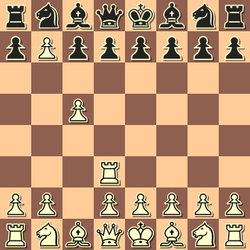

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/rnbqkbnr/pPpppppp/8/2P5/8/3R4/PP1PPPPP/RNBQKBNR)

FEN: rnbqkbnr/pPpppppp/8/2P5/8/3R4/PP1PPPPP/RNBQKBNR


0.99989653

In [38]:
makePrediction('http://www.jinchess.com/chessboard/?p=rnbqkbnrpPpppppp----------P----------------R----PP-PPPPPRNBQKBNR')

Interesting, it doesn't look a CNN solved all of our problems, it comes back to getting better datasets. We need to find a way to programmatically collect more of the piece sets of chess.com, lichess.org and other sites to help round it out. The model is beginning to understand the concept of pieces, and did a valiant effort with boards outside of it's domain, with more data it should get to the point where it will be more useful than not on the chess subreddit.

# Validating with last 100 reddit posts

Okay, I started a basic reddit bot that pulled the 100 most recent posts on the r/chess subreddit, and only chose those that potentially had a chessboard image and the words `white` or `black` in the title, signifying white or black to play. Let's test our predictions on the urls.

---
#0 URL: http://imgur.com/GRcKdds
Image on which to make prediction: http://imgur.com/GRcKdds


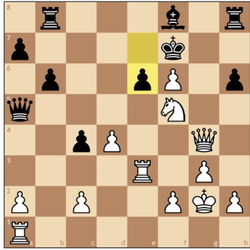

Certainty range [0.996066 - 1], Avg: 0.999937


Prediction: [Lichess analysis](https://lichess.org/analysis/1r3b1r/p4k2/1p2pP1p/q4N2/2pP2Q1/4R1P1/P1P2PKP/R7)

FEN: 1r3b1r/p4k2/1p2pP1p/q4N2/2pP2Q1/4R1P1/P1P2PKP/R7

---
#1 URL: http://imgur.com/I7cgJO0
Image on which to make prediction: http://imgur.com/I7cgJO0


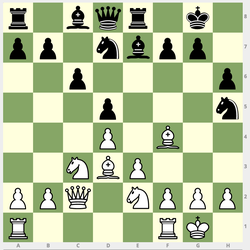

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/r1bqr1k1/pp1nbpp1/2p4p/3p3n/3P1B2/2NBP3/PPQ1NPPP/R4RK1)

FEN: r1bqr1k1/pp1nbpp1/2p4p/3p3n/3P1B2/2NBP3/PPQ1NPPP/R4RK1

---
#2 URL: http://imgur.com/albpHvw
Image on which to make prediction: http://imgur.com/albpHvw


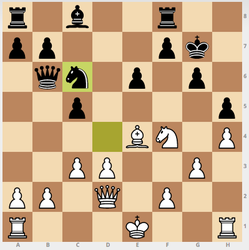

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/r1b2r2/pp3pk1/1qn1p1p1/2p4p/4BN1P/2PP2P1/PP1Q1P2/R3K2R)

FEN: r1b2r2/pp3pk1/1qn1p1p1/2p4p/4BN1P/2PP2P1/PP1Q1P2/R3K2R

---
#3 URL: http://imgur.com/337yNGL
Image on which to make prediction: http://imgur.com/337yNGL


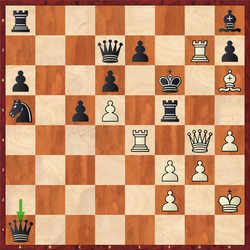

Certainty range [0.999968 - 1], Avg: 0.999994


Prediction: [Lichess analysis](https://lichess.org/analysis/r6b/3qp1Rp/p2p1k1B/n1pP1r2/4R1QP/5PP1/5P1K/q7)

FEN: r6b/3qp1Rp/p2p1k1B/n1pP1r2/4R1QP/5PP1/5P1K/q7

---
#4 URL: http://i.imgur.com/WcKpzN2.jpg
Image on which to make prediction: http://i.imgur.com/WcKpzN2.jpg


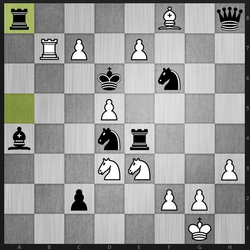

Certainty range [0.99998 - 1], Avg: 0.999996


Prediction: [Lichess analysis](https://lichess.org/analysis/r4B1q/1RP1P3/3k1n2/3P4/b2nr3/3NN2P/2p2PP1/6K1)

FEN: r4B1q/1RP1P3/3k1n2/3P4/b2nr3/3NN2P/2p2PP1/6K1

---
#5 URL: http://i.imgur.com/PmALkwI.png
Image on which to make prediction: http://i.imgur.com/PmALkwI.png


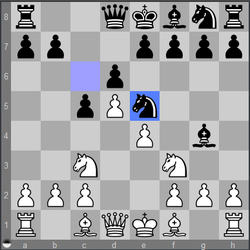

Trying 90% of threshold
Certainty range [0.999946 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/r2qkbnr/pp2pppp/3p4/2pPn3/4P1b1/2N2N2/PPP2PPP/R1BQKB1R)

FEN: r2qkbnr/pp2pppp/3p4/2pPn3/4P1b1/2N2N2/PPP2PPP/R1BQKB1R

---
#6 URL: http://imgur.com/YPmOUCU
Image on which to make prediction: http://imgur.com/YPmOUCU


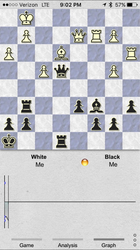

Certainty range [0.999988 - 1], Avg: 0.999996


Prediction: [Lichess analysis](https://lichess.org/analysis/1K6/1P2QRP1/P2B3R/2Pq2P1/8/1r2pb1p/pp3pp1/k2r4)

FEN: 1K6/1P2QRP1/P2B3R/2Pq2P1/8/1r2pb1p/pp3pp1/k2r4

---
#7 URL: http://i.imgur.com/Xb01wTO.png
Image on which to make prediction: http://i.imgur.com/Xb01wTO.png


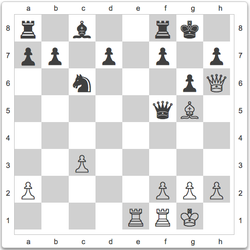

Certainty range [0.559677 - 1], Avg: 0.980924


Prediction: [Lichess analysis](https://lichess.org/analysis/r1p2rk1/pp1p1p1p/2n3pQ/5qp1/8/2P5/P4PPP/4RRK1)

FEN: r1p2rk1/pp1p1p1p/2n3pQ/5qp1/8/2P5/P4PPP/4RRK1

---
#8 URL: http://imgur.com/CzdxVkB
Image on which to make prediction: http://imgur.com/CzdxVkB


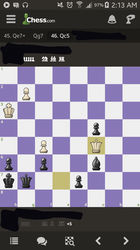

Certainty range [0.511607 - 1], Avg: 0.981268


Prediction: [Lichess analysis](https://lichess.org/analysis/8/1P6/Q7/5p2/2P2Q2/p1p2b2/kp2p3/8)

FEN: 8/1P6/Q7/5p2/2P2Q2/p1p2b2/kp2p3/8

---
#9 URL: http://imgur.com/14PMpto
Image on which to make prediction: http://imgur.com/14PMpto


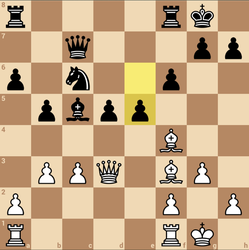

Certainty range [0.999995 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/r4rk1/2q3pp/p1n2p2/1pbpp3/5B2/1PPQ1BP1/P4P1P/R4RK1)

FEN: r4rk1/2q3pp/p1n2p2/1pbpp3/5B2/1PPQ1BP1/P4P1P/R4RK1

---
#10 URL: http://imgur.com/i5qKESq
Image on which to make prediction: http://imgur.com/i5qKESq


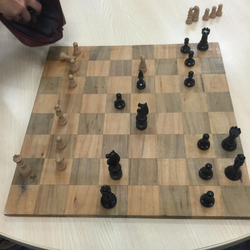

Trying 90% of threshold
Trying 80% of threshold
Trying 70% of threshold
Trying 60% of threshold
	No Match, lines found (dx/dy): [] []
Couldn't parse chessboard

---
#11 URL: http://imgur.com/95XC1J5
Image on which to make prediction: http://imgur.com/95XC1J5


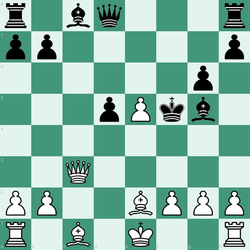

Certainty range [0.986392 - 1], Avg: 0.999546


Prediction: [Lichess analysis](https://lichess.org/analysis/r1bq3r/pp5p/6p1/3pPkb1/8/2Q5/PP2BPPP/R1B1K2R)

FEN: r1bq3r/pp5p/6p1/3pPkb1/8/2Q5/PP2BPPP/R1B1K2R

---
#12 URL: http://i.imgur.com/XBkHk26.png
Image on which to make prediction: http://i.imgur.com/XBkHk26.png


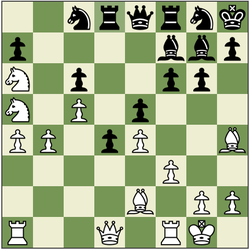

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/2nrqrnk/p4bbp/N1p2pp1/N1P1p3/PP1pP2B/5P2/4B1PP/R2Q1RK1)

FEN: 2nrqrnk/p4bbp/N1p2pp1/N1P1p3/PP1pP2B/5P2/4B1PP/R2Q1RK1

---
#13 URL: http://imgur.com/4qL270K
Image on which to make prediction: http://imgur.com/4qL270K


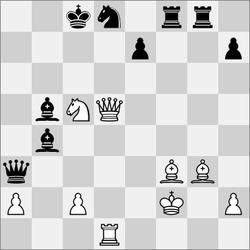

Certainty range [0.999996 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/2kn1rr1/4p2p/8/1bNQ4/1b6/q4BB1/P1P2K1P/3R4)

FEN: 2kn1rr1/4p2p/8/1bNQ4/1b6/q4BB1/P1P2K1P/3R4

---
#14 URL: http://i.imgur.com/FPnkfJO.png
Image on which to make prediction: http://i.imgur.com/FPnkfJO.png


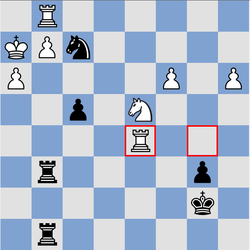

Certainty range [0.999992 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/1R6/KPn5/P4P1P/2p1N3/4R3/1r4p1/6k1/1r6)

FEN: 1R6/KPn5/P4P1P/2p1N3/4R3/1r4p1/6k1/1r6

---
#15 URL: http://imgur.com/ut6RKyl
Image on which to make prediction: http://imgur.com/ut6RKyl


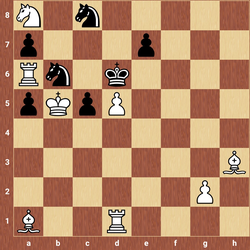

Certainty range [0.999972 - 1], Avg: 0.999989


Prediction: [Lichess analysis](https://lichess.org/analysis/N1n5/p3p3/Rn1k4/pKpP4/8/7B/6P1/B2R4)

FEN: N1n5/p3p3/Rn1k4/pKpP4/8/7B/6P1/B2R4

---
#16 URL: http://imgur.com/qtXuMkR
Image on which to make prediction: http://imgur.com/qtXuMkR


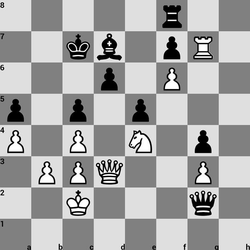

Certainty range [0.999993 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/5r2/2kb1pR1/3p1P2/p1p1p3/P1P1N1p1/1PPQ2P1/2K3q1/8)

FEN: 5r2/2kb1pR1/3p1P2/p1p1p3/P1P1N1p1/1PPQ2P1/2K3q1/8

---
#17 URL: http://i.imgur.com/yRBJHc7.png
Image on which to make prediction: http://i.imgur.com/yRBJHc7.png


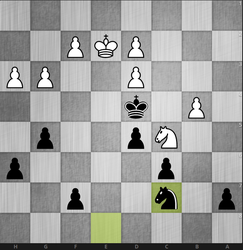

Certainty range [0.999954 - 1], Avg: 0.999995


Prediction: [Lichess analysis](https://lichess.org/analysis/8/2PKP3/PP2P3/4k1P1/1p2pN2/p4p2/2p2n1p/8)

FEN: 8/2PKP3/PP2P3/4k1P1/1p2pN2/p4p2/2p2n1p/8

---
#18 URL: http://imgur.com/b9zxOOd
Image on which to make prediction: http://imgur.com/b9zxOOd


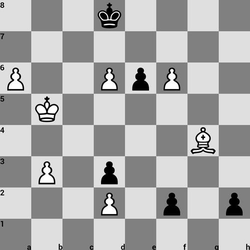

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/3k4/8/P2PpP2/1K6/6B1/1P1p4/3P1p1p/8)

FEN: 3k4/8/P2PpP2/1K6/6B1/1P1p4/3P1p1p/8

---
#19 URL: http://imgur.com/SeJasRQ
Image on which to make prediction: http://imgur.com/SeJasRQ


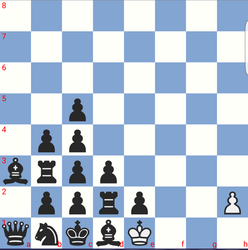

Certainty range [0.999972 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/8/8/8/2p5/1pp5/brpp4/1pprp2P/qnkbK3)

FEN: 8/8/8/2p5/1pp5/brpp4/1pprp2P/qnkbK3

---
#20 URL: http://i.imgur.com/FTjNkP5.png
Image on which to make prediction: http://i.imgur.com/FTjNkP5.png


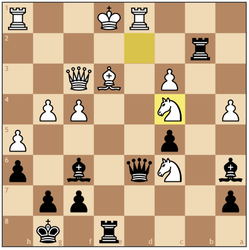

Certainty range [0.999414 - 1], Avg: 0.999989


Prediction: [Lichess analysis](https://lichess.org/analysis/R2KR3/6r1/2QB1P2/1PP2N1P/P4p2/p1b1qN1b/1pp4p/1k1r4)

FEN: R2KR3/6r1/2QB1P2/1PP2N1P/P4p2/p1b1qN1b/1pp4p/1k1r4

---
#21 URL: https://i.imgur.com/M13bNGb.png
Image on which to make prediction: https://i.imgur.com/M13bNGb.png


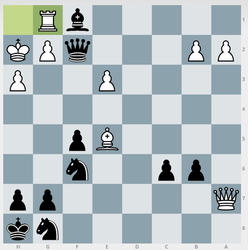

Certainty range [0.999996 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/1Rb5/KPq3PP/P2P4/8/2pB4/2n2pp1/pp5Q/kn6)

FEN: 1Rb5/KPq3PP/P2P4/8/2pB4/2n2pp1/pp5Q/kn6

---
#22 URL: http://imgur.com/x0XzwJh
Image on which to make prediction: http://imgur.com/x0XzwJh


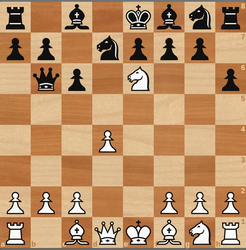

Certainty range [0.999991 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/r1b1kbnr/pp1nppp1/1qp1N2p/8/3P4/8/PPP2PPP/R1BQKBNR)

FEN: r1b1kbnr/pp1nppp1/1qp1N2p/8/3P4/8/PPP2PPP/R1BQKBNR

---
#23 URL: http://imgur.com/u7D5Fkc
Image on which to make prediction: http://imgur.com/u7D5Fkc


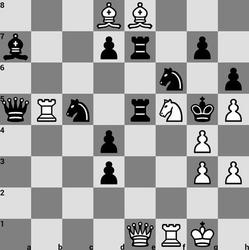

Certainty range [0.999987 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/3BB3/b2pr1p1/5n1p/qRn1rNkP/3p2P1/3p2PP/8/4QRK1)

FEN: 3BB3/b2pr1p1/5n1p/qRn1rNkP/3p2P1/3p2PP/8/4QRK1

---
#24 URL: http://imgur.com/BUqCNsI
Image on which to make prediction: http://imgur.com/BUqCNsI


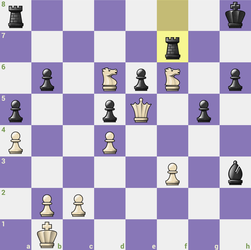

Certainty range [0.494627 - 1], Avg: 0.968582


Prediction: [Lichess analysis](https://lichess.org/analysis/r6n/5r2/1p1QpQ1p/p2pQ1p1/P2P4/5P1b/1PP5/1Q6)

FEN: r6n/5r2/1p1QpQ1p/p2pQ1p1/P2P4/5P1b/1PP5/1Q6

---
#25 URL: http://i.imgur.com/ZGRgL16.jpg
Image on which to make prediction: http://i.imgur.com/ZGRgL16.jpg


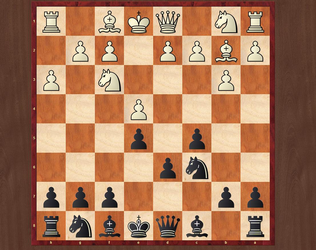

Certainty range [0.999979 - 1], Avg: 0.999995


Prediction: [Lichess analysis](https://lichess.org/analysis/R1BKQ1NR/1PP1PPBP/P1N3P1/3P4/3p1p2/4pn2/ppp3pp/rnbkqb1r)

FEN: R1BKQ1NR/1PP1PPBP/P1N3P1/3P4/3p1p2/4pn2/ppp3pp/rnbkqb1r

---
#26 URL: http://imgur.com/63rBqFR
Image on which to make prediction: http://imgur.com/63rBqFR


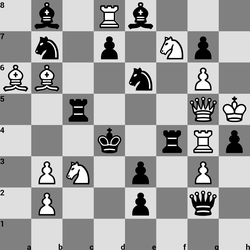

Certainty range [0.999991 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/1b1Rb3/1n1p1Np1/BB2n1P1/2r3QK/3k1rRp/1PN1p1P1/1P2p1q1/8)

FEN: 1b1Rb3/1n1p1Np1/BB2n1P1/2r3QK/3k1rRp/1PN1p1P1/1P2p1q1/8

---
#27 URL: http://imgur.com/evDUNw8
Image on which to make prediction: http://imgur.com/evDUNw8


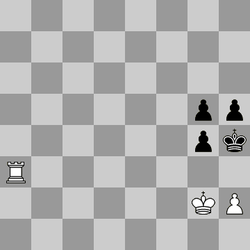

Certainty range [0.999996 - 1], Avg: 0.999996


Prediction: [Lichess analysis](https://lichess.org/analysis/8/8/8/6pp/6pk/R7/6KP/8)

FEN: 8/8/8/6pp/6pk/R7/6KP/8

---
#28 URL: http://imgur.com/Mz4ynW6
Image on which to make prediction: http://imgur.com/Mz4ynW6


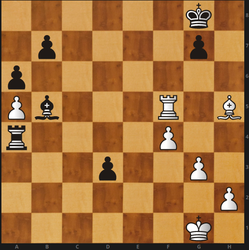

Certainty range [0.999898 - 1], Avg: 0.999996


Prediction: [Lichess analysis](https://lichess.org/analysis/6k1/1p4p1/p7/Pb3R1B/r4P2/3p2P1/7P/6K1)

FEN: 6k1/1p4p1/p7/Pb3R1B/r4P2/3p2P1/7P/6K1

---
#29 URL: http://imgur.com/J0VzskZ
Image on which to make prediction: http://imgur.com/J0VzskZ


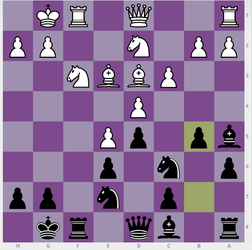

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/1KR1Q2R/PP2N1PP/2NBBP2/4P3/3Pp1pb/3p1n1p/pp1n1p2/1kr1qb1r)

FEN: 1KR1Q2R/PP2N1PP/2NBBP2/4P3/3Pp1pb/3p1n1p/pp1n1p2/1kr1qb1r

---
#30 URL: http://i.imgur.com/KMSYQKk.png
Image on which to make prediction: http://i.imgur.com/KMSYQKk.png


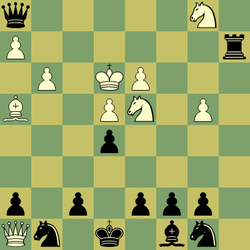

Certainty range [0.988973 - 1], Avg: 0.99947


Prediction: [Lichess analysis](https://lichess.org/analysis/q5N1/P6r/1P1KP3/B2PN1P1/3p4/8/p1p1ppp1/Qn1k1bn1)

FEN: q5N1/P6r/1P1KP3/B2PN1P1/3p4/8/p1p1ppp1/Qn1k1bn1

---
#31 URL: http://imgur.com/4oWNIa0
Image on which to make prediction: http://imgur.com/4oWNIa0


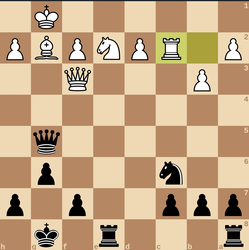

Certainty range [0.999996 - 1], Avg: 0.999999


Prediction: [Lichess analysis](https://lichess.org/analysis/1K6/PBPNPR1P/2Q3P1/8/1q6/1p3n2/p1p2ppp/1k1r3r)

FEN: 1K6/PBPNPR1P/2Q3P1/8/1q6/1p3n2/p1p2ppp/1k1r3r

---
#32 URL: http://i.imgur.com/BuAs7zT.png
Image on which to make prediction: http://i.imgur.com/BuAs7zT.png


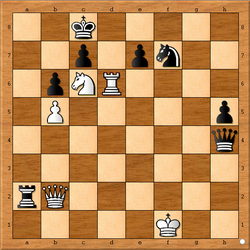

Certainty range [0.999855 - 1], Avg: 0.999995


Prediction: [Lichess analysis](https://lichess.org/analysis/2k5/2p1pn2/1pNR4/1P5p/7q/8/rQ6/5K2)

FEN: 2k5/2p1pn2/1pNR4/1P5p/7q/8/rQ6/5K2

---
#33 URL: http://i.imgur.com/OsFNmIA.png
Image on which to make prediction: http://i.imgur.com/OsFNmIA.png


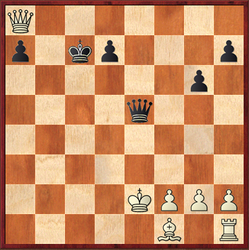

Certainty range [0.999753 - 1], Avg: 0.999985


Prediction: [Lichess analysis](https://lichess.org/analysis/Q7/p1kp3p/6p1/4q3/8/8/4KPPP/5B1R)

FEN: Q7/p1kp3p/6p1/4q3/8/8/4KPPP/5B1R

---
#34 URL: http://imgur.com/iTEr7aT
Image on which to make prediction: http://imgur.com/iTEr7aT


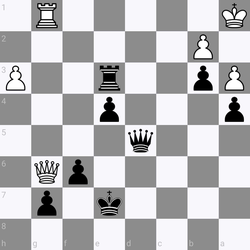

Certainty range [0.999774 - 1], Avg: 0.99999


Prediction: [Lichess analysis](https://lichess.org/analysis/1R5K/6P1/P2r2pP/3p3p/4q3/1Qp5/1p1k4/8)

FEN: 1R5K/6P1/P2r2pP/3p3p/4q3/1Qp5/1p1k4/8

---
#35 URL: http://i.imgur.com/DxJLdC9.png
Image on which to make prediction: http://i.imgur.com/DxJLdC9.png


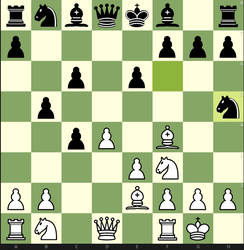

Certainty range [0.999996 - 1], Avg: 0.999999


Prediction: [Lichess analysis](https://lichess.org/analysis/rnbqkb1r/p4ppp/2p1p3/1p5n/2pP1B2/4PN2/PP2BPPP/RN1Q1RK1)

FEN: rnbqkb1r/p4ppp/2p1p3/1p5n/2pP1B2/4PN2/PP2BPPP/RN1Q1RK1

---
#36 URL: http://imgur.com/YI0xoaV
Image on which to make prediction: http://imgur.com/YI0xoaV


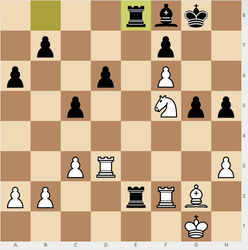

Certainty range [0.999996 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/4rbk1/1p3p2/p2p1P2/2p2Npp/8/2PR3P/PP2rRB1/6K1)

FEN: 4rbk1/1p3p2/p2p1P2/2p2Npp/8/2PR3P/PP2rRB1/6K1

---
#37 URL: http://i.imgur.com/9WxZgtf.png
Image on which to make prediction: http://i.imgur.com/9WxZgtf.png


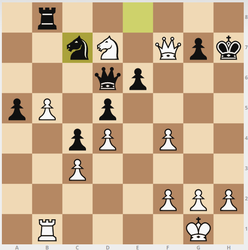

Certainty range [0.999996 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/1r6/2nN1Qpk/3qp3/pP1p4/2pP1P2/2P5/5PPP/1R4K1)

FEN: 1r6/2nN1Qpk/3qp3/pP1p4/2pP1P2/2P5/5PPP/1R4K1

---
#38 URL: http://imgur.com/lJLsGU0
Image on which to make prediction: http://imgur.com/lJLsGU0


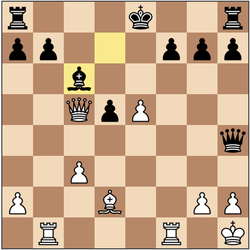

Certainty range [0.999996 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/r3k2r/pp3ppp/2b5/2QpP3/7q/2P5/P2B2PP/1R3R1K)

FEN: r3k2r/pp3ppp/2b5/2QpP3/7q/2P5/P2B2PP/1R3R1K

---
#39 URL: http://i.imgur.com/Shr4bwr.jpg
Image on which to make prediction: http://i.imgur.com/Shr4bwr.jpg


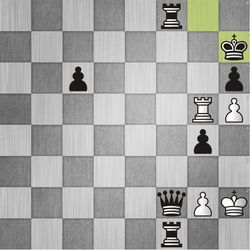

Certainty range [0.999974 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/5r2/7k/2p4p/6RP/6p1/8/5qPK/5r2)

FEN: 5r2/7k/2p4p/6RP/6p1/8/5qPK/5r2

---
#40 URL: http://imgur.com/L25DgOj
Image on which to make prediction: http://imgur.com/L25DgOj


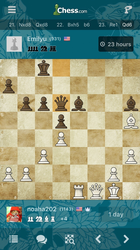

Certainty range [0.513564 - 1], Avg: 0.942083


Prediction: [Lichess analysis](https://lichess.org/analysis/2k5/b7/1ppqb2b/3p3B/3P4/2P4P/PB4P1/4RQR1)

FEN: 2k5/b7/1ppqb2b/3p3B/3P4/2P4P/PB4P1/4RQR1

---
#41 URL: http://imgur.com/fMIzftn
Image on which to make prediction: http://imgur.com/fMIzftn


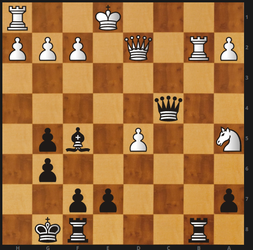

Certainty range [0.999761 - 1], Avg: 0.999988


Prediction: [Lichess analysis](https://lichess.org/analysis/R2K4/PPP1Q1RP/8/5q2/1pb1P2N/1p6/2pp3p/1kr3r1)

FEN: R2K4/PPP1Q1RP/8/5q2/1pb1P2N/1p6/2pp3p/1kr3r1

---
#42 URL: http://imgur.com/g7XiYrH
Image on which to make prediction: http://imgur.com/g7XiYrH


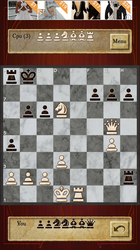

Certainty range [0.398337 - 1], Avg: 0.973383


Prediction: [Lichess analysis](https://lichess.org/analysis/rq6/5ppp/1ppN4/6Q1/p5P1/3P4/PPP4r/3KR3)

FEN: rq6/5ppp/1ppN4/6Q1/p5P1/3P4/PPP4r/3KR3

---
#43 URL: http://i.imgur.com/MLPHSKo.jpg
Image on which to make prediction: http://i.imgur.com/MLPHSKo.jpg


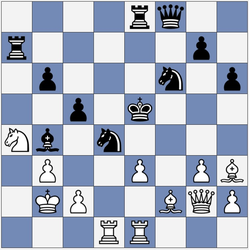

Certainty range [0.998995 - 1], Avg: 0.999984


Prediction: [Lichess analysis](https://lichess.org/analysis/4rq2/r5p1/1p3n1p/2p1k3/Nb1n4/1P2P1PB/1KP2BQP/3RR3)

FEN: 4rq2/r5p1/1p3n1p/2p1k3/Nb1n4/1P2P1PB/1KP2BQP/3RR3

---
#44 URL: http://imgur.com/b5EMIDK
Image on which to make prediction: http://imgur.com/b5EMIDK


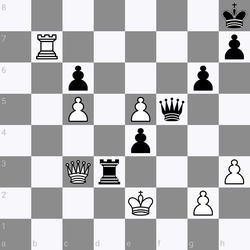

Certainty range [0.999767 - 1], Avg: 0.99999


Prediction: [Lichess analysis](https://lichess.org/analysis/7k/1R5p/2p3p1/2P1Pq2/4p3/2Qr3P/4K1P1/8)

FEN: 7k/1R5p/2p3p1/2P1Pq2/4p3/2Qr3P/4K1P1/8

---
#45 URL: http://imgur.com/Ym0w7dw
Image on which to make prediction: http://imgur.com/Ym0w7dw


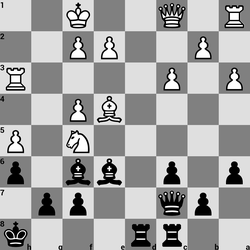

Certainty range [0.999994 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/2K2Q1R/2PP2P1/R4P1P/2PB4/P1N5/p1bb1p1p/1pp2qp1/k3rr2)

FEN: 2K2Q1R/2PP2P1/R4P1P/2PB4/P1N5/p1bb1p1p/1pp2qp1/k3rr2

---
#46 URL: http://m.imgur.com/a/A6nWF
Couldn't load image url: http://m.imgur.com/a/A6nWF

---
#47 URL: http://imgur.com/lFgeyxi
Image on which to make prediction: http://imgur.com/lFgeyxi


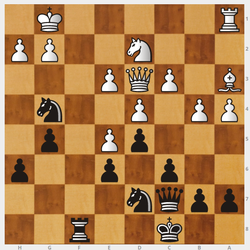

Certainty range [0.999819 - 1], Avg: 0.999992


Prediction: [Lichess analysis](https://lichess.org/analysis/1K5R/PP2N3/3PQP1B/1n2P1PP/1p1Pp3/p2p1p2/4nqpp/2r2k2)

FEN: 1K5R/PP2N3/3PQP1B/1n2P1PP/1p1Pp3/p2p1p2/4nqpp/2r2k2

---
#48 URL: http://imgur.com/h4cn4KE
Image on which to make prediction: http://imgur.com/h4cn4KE


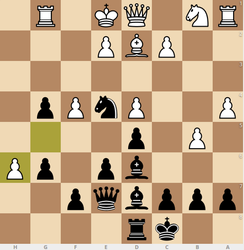

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/1R1KQ1NR/3PBP2/8/1pPnP2P/4p1P1/Pp1pb3/2pqbppp/4rk2)

FEN: 1R1KQ1NR/3PBP2/8/1pPnP2P/4p1P1/Pp1pb3/2pqbppp/4rk2

---
#49 URL: http://imgur.com/b5XQ1uJ
Image on which to make prediction: http://imgur.com/b5XQ1uJ


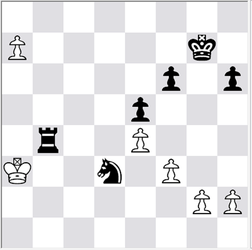

Certainty range [0.979003 - 1], Avg: 0.999661


Prediction: [Lichess analysis](https://lichess.org/analysis/8/P5k1/5p1p/4p3/1r2P3/K2n1P2/6PP/8)

FEN: 8/P5k1/5p1p/4p3/1r2P3/K2n1P2/6PP/8

---
#50 URL: http://imgur.com/gInXR9K
Image on which to make prediction: http://imgur.com/gInXR9K


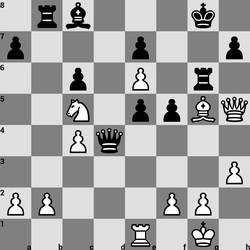

Certainty range [0.999991 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/1rb3k1/p3p2p/2p1P1r1/2N1ppBQ/2Pq4/7P/PP3PP1/4R1K1)

FEN: 1rb3k1/p3p2p/2p1P1r1/2N1ppBQ/2Pq4/7P/PP3PP1/4R1K1

---
#51 URL: https://imgur.com/A3KmcDG
Image on which to make prediction: https://imgur.com/A3KmcDG


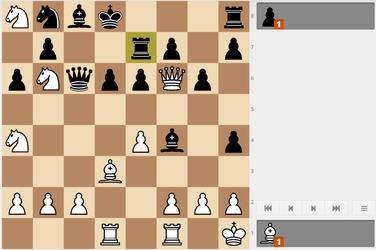

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/Nnbk3r/1p2rp1p/pNqppQp1/8/N3Pb1p/3B4/PPP2PPP/3R1R1K)

FEN: Nnbk3r/1p2rp1p/pNqppQp1/8/N3Pb1p/3B4/PPP2PPP/3R1R1K

---
#52 URL: http://imgur.com/mTCtcel
Image on which to make prediction: http://imgur.com/mTCtcel


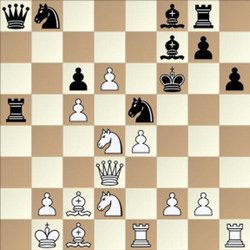

Certainty range [0.999793 - 1], Avg: 0.999991


Prediction: [Lichess analysis](https://lichess.org/analysis/qn3br1/5bp1/2pP1k1p/r1P1n3/3NP3/3Q4/1PBN1PP1/1KB1R2R)

FEN: qn3br1/5bp1/2pP1k1p/r1P1n3/3NP3/3Q4/1PBN1PP1/1KB1R2R

---
#53 URL: http://imgur.com/o96Rtfn
Image on which to make prediction: http://imgur.com/o96Rtfn


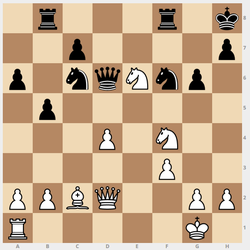

Certainty range [0.999996 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/1r3r1k/2p4p/p1nqNnp1/1p6/3P1N2/5P2/PPBQ2PP/R5K1)

FEN: 1r3r1k/2p4p/p1nqNnp1/1p6/3P1N2/5P2/PPBQ2PP/R5K1

---
#54 URL: http://imgur.com/yIKiRN7
Image on which to make prediction: http://imgur.com/yIKiRN7


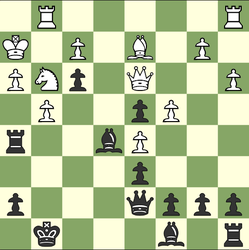

Certainty range [0.98647 - 1], Avg: 0.999722


Prediction: [Lichess analysis](https://lichess.org/analysis/1R5R/K1P1B1P1/PNp1Q2P/1P2pP2/r2bP3/4p3/p3qppp/1k3b1r)

FEN: 1R5R/K1P1B1P1/PNp1Q2P/1P2pP2/r2bP3/4p3/p3qppp/1k3b1r

---
#55 URL: http://imgur.com/g7IYvwI
Image on which to make prediction: http://imgur.com/g7IYvwI


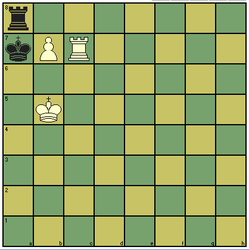

Trying 90% of threshold
Trying 80% of threshold
Trying 70% of threshold
Trying 60% of threshold
	No Match, lines found (dx/dy): [] []
Couldn't parse chessboard

---
#56 URL: http://i.imgur.com/EMHtHay.png
Image on which to make prediction: http://i.imgur.com/EMHtHay.png


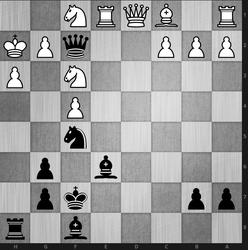

Certainty range [0.999954 - 1], Avg: 0.999996


Prediction: [Lichess analysis](https://lichess.org/analysis/2NRQB1R/KPq2PPP/P1N5/2P5/2n5/1p1b4/1pk3pp/r1b5)

FEN: 2NRQB1R/KPq2PPP/P1N5/2P5/2n5/1p1b4/1pk3pp/r1b5

---
#57 URL: http://i.imgur.com/aL64q8w.png
Image on which to make prediction: http://i.imgur.com/aL64q8w.png


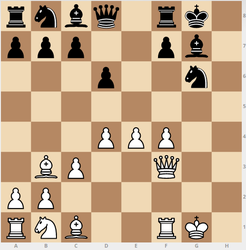

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/rnbq1rk1/ppp2pb1/3p2n1/8/3PPP2/1BP2Q2/PP6/RNB2RK1)

FEN: rnbq1rk1/ppp2pb1/3p2n1/8/3PPP2/1BP2Q2/PP6/RNB2RK1

---
#58 URL: http://imgur.com/FtcZA47
Image on which to make prediction: http://imgur.com/FtcZA47


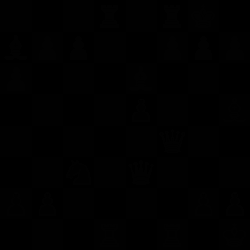

Certainty range [0.999996 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/3r1rk1/bpp2ppp/p3b3/4P2B/5Q2/2N1q3/PP4PP/3R1R1K)

FEN: 3r1rk1/bpp2ppp/p3b3/4P2B/5Q2/2N1q3/PP4PP/3R1R1K

---
#59 URL: http://i.imgur.com/wrXjbe8.png
Image on which to make prediction: http://i.imgur.com/wrXjbe8.png


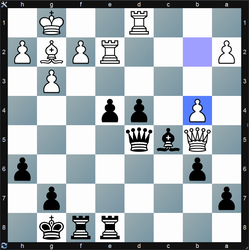

Certainty range [0.998219 - 1], Avg: 0.999969


Prediction: [Lichess analysis](https://lichess.org/analysis/1K2R3/PBPR3P/1P6/3pp1P1/4qbQ1/p5p1/1p5p/1krr4)

FEN: 1K2R3/PBPR3P/1P6/3pp1P1/4qbQ1/p5p1/1p5p/1krr4

---
#60 URL: http://imgur.com/u4zF5Hj
Image on which to make prediction: http://imgur.com/u4zF5Hj


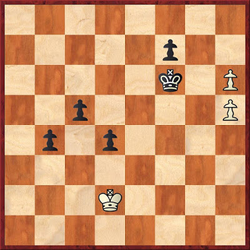

Certainty range [0.999545 - 1], Avg: 0.999977


Prediction: [Lichess analysis](https://lichess.org/analysis/8/5p2/5k1P/2p4P/1p1p4/8/3K4/8)

FEN: 8/5p2/5k1P/2p4P/1p1p4/8/3K4/8

---
#61 URL: http://i.imgur.com/gSFbM1d.png
Image on which to make prediction: http://i.imgur.com/gSFbM1d.png


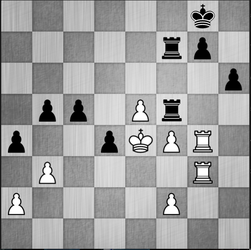

Certainty range [0.999988 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/6k1/5rp1/7p/1pp1Pr2/p2pKPR1/1P4R1/P4P2/8)

FEN: 6k1/5rp1/7p/1pp1Pr2/p2pKPR1/1P4R1/P4P2/8

---
#62 URL: http://i.imgur.com/TeHm97Z.jpg
Image on which to make prediction: http://i.imgur.com/TeHm97Z.jpg


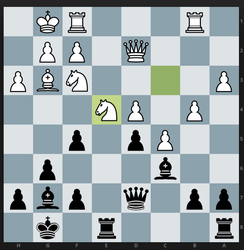

Certainty range [0.999996 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/1KR3R1/1PP1Q3/PBN4P/3NP1P1/2p1pP2/1p3b2/pbp1q1pp/1k1r3r)

FEN: 1KR3R1/1PP1Q3/PBN4P/3NP1P1/2p1pP2/1p3b2/pbp1q1pp/1k1r3r

---
#63 URL: http://imgur.com/dZDSzAa
Image on which to make prediction: http://imgur.com/dZDSzAa


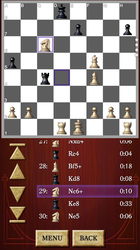

Certainty range [0.534192 - 1], Avg: 0.972101


Prediction: [Lichess analysis](https://lichess.org/analysis/3p4/4p2p/2r5/p4P2/2r2P2/8/PP3PPP/3PB2P)

FEN: 3p4/4p2p/2r5/p4P2/2r2P2/8/PP3PPP/3PB2P

---
#64 URL: http://i.imgur.com/taNJN7h.png
Image on which to make prediction: http://i.imgur.com/taNJN7h.png


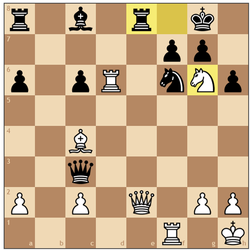

Certainty range [0.999994 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/r1b1r1k1/5pp1/p1pR1nNp/8/2B5/2q5/P1P1Q1PP/5R1K)

FEN: r1b1r1k1/5pp1/p1pR1nNp/8/2B5/2q5/P1P1Q1PP/5R1K

---
#65 URL: http://imgur.com/qk5xa6q
Image on which to make prediction: http://imgur.com/qk5xa6q


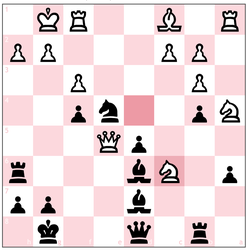

Certainty range [0.527064 - 1], Avg: 0.990506


Prediction: [Lichess analysis](https://lichess.org/analysis/1KR2B1R/PP3PP1/2P3P1/2pn2pn/3Qp3/r3bB1p/pp2b3/1k2q1r1)

FEN: 1KR2B1R/PP3PP1/2P3P1/2pn2pn/3Qp3/r3bB1p/pp2b3/1k2q1r1

---
#66 URL: http://imgur.com/oXpMSQI
Image on which to make prediction: http://imgur.com/oXpMSQI


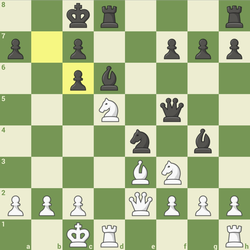

Certainty range [0.998874 - 1], Avg: 0.99992


Prediction: [Lichess analysis](https://lichess.org/analysis/2kr3r/p1p2ppp/2pb4/3N1q2/4n1b1/4BN2/PPP1QPPP/2KR3R)

FEN: 2kr3r/p1p2ppp/2pb4/3N1q2/4n1b1/4BN2/PPP1QPPP/2KR3R

---
#67 URL: http://imgur.com/r2r43xA
Image on which to make prediction: http://imgur.com/r2r43xA


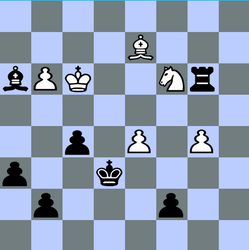

Certainty range [0.645451 - 1], Avg: 0.980475


Prediction: [Lichess analysis](https://lichess.org/analysis/8/4B3/bBK2Nr1/8/2b1B1B1/p2k4/1p3p2/8)

FEN: 8/4B3/bBK2Nr1/8/2b1B1B1/p2k4/1p3p2/8

---
#68 URL: http://i.imgur.com/x6lLQQK.png
Image on which to make prediction: http://i.imgur.com/x6lLQQK.png


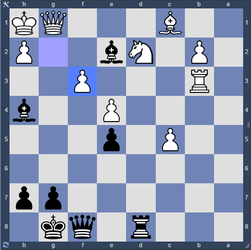

Certainty range [0.999977 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/KQ3B2/P2bN1P1/2P3R1/b2P4/3p1P2/8/pp6/1kq1r3)

FEN: KQ3B2/P2bN1P1/2P3R1/b2P4/3p1P2/8/pp6/1kq1r3

---
#69 URL: http://imgur.com/bkn5nn4
Image on which to make prediction: http://imgur.com/bkn5nn4


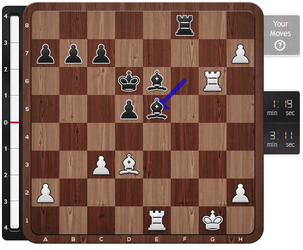

Trying 90% of threshold
Certainty range [0.44369 - 1], Avg: 0.968921


Prediction: [Lichess analysis](https://lichess.org/analysis/5q2/ppp4B/3kb1R1/3pq3/8/2BB4/P6B/4R1K1)

FEN: 5q2/ppp4B/3kb1R1/3pq3/8/2BB4/P6B/4R1K1

---
#70 URL: http://i.imgur.com/HnWYt8A.png
Image on which to make prediction: http://i.imgur.com/HnWYt8A.png


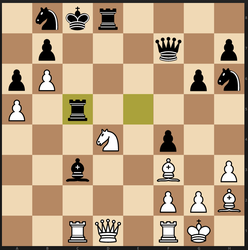

Certainty range [0.999995 - 1], Avg: 0.999999


Prediction: [Lichess analysis](https://lichess.org/analysis/1nkr4/1p3q1p/pP4pn/P1r5/3N1p2/2b2B1P/5PPB/2RQ1RK1)

FEN: 1nkr4/1p3q1p/pP4pn/P1r5/3N1p2/2b2B1P/5PPB/2RQ1RK1



In [39]:
reddit_urls = [u'http://imgur.com/GRcKdds',
 u'http://imgur.com/I7cgJO0',
 u'http://imgur.com/albpHvw',
 u'http://imgur.com/337yNGL',
 u'http://i.imgur.com/WcKpzN2.jpg',
 u'http://i.imgur.com/PmALkwI.png',
 u'http://imgur.com/YPmOUCU',
 u'http://i.imgur.com/Xb01wTO.png',
 u'http://imgur.com/CzdxVkB',
 u'http://imgur.com/14PMpto',
 u'http://imgur.com/i5qKESq',
 u'http://imgur.com/95XC1J5',
 u'http://i.imgur.com/XBkHk26.png',
 u'http://imgur.com/4qL270K',
 u'http://i.imgur.com/FPnkfJO.png',
 u'http://imgur.com/ut6RKyl',
 u'http://imgur.com/qtXuMkR',
 u'http://i.imgur.com/yRBJHc7.png',
 u'http://imgur.com/b9zxOOd',
 u'http://imgur.com/SeJasRQ',
 u'http://i.imgur.com/FTjNkP5.png',
 u'https://i.imgur.com/M13bNGb.png',
 u'http://imgur.com/x0XzwJh',
 u'http://imgur.com/u7D5Fkc',
 u'http://imgur.com/BUqCNsI',
 u'http://i.imgur.com/ZGRgL16.jpg',
 u'http://imgur.com/63rBqFR',
 u'http://imgur.com/evDUNw8',
 u'http://imgur.com/Mz4ynW6',
 u'http://imgur.com/J0VzskZ',
 u'http://i.imgur.com/KMSYQKk.png',
 u'http://imgur.com/4oWNIa0',
 u'http://i.imgur.com/BuAs7zT.png',
 u'http://i.imgur.com/OsFNmIA.png',
 u'http://imgur.com/iTEr7aT',
 u'http://i.imgur.com/DxJLdC9.png',
 u'http://imgur.com/YI0xoaV',
 u'http://i.imgur.com/9WxZgtf.png',
 u'http://imgur.com/lJLsGU0',
 u'http://i.imgur.com/Shr4bwr.jpg',
 u'http://imgur.com/L25DgOj',
 u'http://imgur.com/fMIzftn',
 u'http://imgur.com/g7XiYrH',
 u'http://i.imgur.com/MLPHSKo.jpg',
 u'http://imgur.com/b5EMIDK',
 u'http://imgur.com/Ym0w7dw',
 u'http://m.imgur.com/a/A6nWF',
 u'http://imgur.com/lFgeyxi',
 u'http://imgur.com/h4cn4KE',
 u'http://imgur.com/b5XQ1uJ',
 u'http://imgur.com/gInXR9K',
 u'https://imgur.com/A3KmcDG',
 u'http://imgur.com/mTCtcel',
 u'http://imgur.com/o96Rtfn',
 u'http://imgur.com/yIKiRN7',
 u'http://imgur.com/g7IYvwI',
 u'http://i.imgur.com/EMHtHay.png',
 u'http://i.imgur.com/aL64q8w.png',
 u'http://imgur.com/FtcZA47',
 u'http://i.imgur.com/wrXjbe8.png',
 u'http://imgur.com/u4zF5Hj',
 u'http://i.imgur.com/gSFbM1d.png',
 u'http://i.imgur.com/TeHm97Z.jpg',
 u'http://imgur.com/dZDSzAa',
 u'http://i.imgur.com/taNJN7h.png',
 u'http://imgur.com/qk5xa6q',
 u'http://imgur.com/oXpMSQI',
 u'http://imgur.com/r2r43xA',
 u'http://i.imgur.com/x6lLQQK.png',
 u'http://imgur.com/bkn5nn4',
 u'http://i.imgur.com/HnWYt8A.png']

probs = np.zeros(len(reddit_urls))
for i, validate_url in enumerate(reddit_urls):
    print "---"
    print "#%d URL: %s" % (i, validate_url)
    probs[i] = makePrediction(validate_url)
    print

21/71 with certainties under 99.9%
16/71 with certainties under 99%
15/71 with certainties under 98%
12/71 with certainties under 95%
12/71 with certainties under 90%
12/71 with certainties under 80%
12/71 with certainties under 70%
12/71 with certainties under 60%
12/71 with certainties under 50%


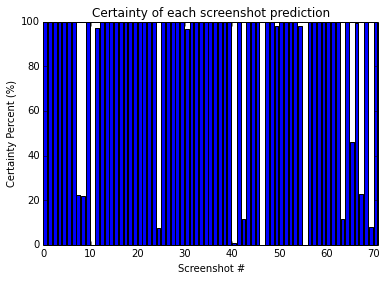

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in [0.999, 0.99, 0.98, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5]:
    print "%d/%d with certainties under %g%%" % (np.sum(probs < i), probs.size, (i*100))

plt.bar(np.arange(len(probs)), probs*100)
plt.xlabel('Screenshot #')
plt.ylabel('Certainty Percent (%)')
plt.title('Certainty of each screenshot prediction')
plt.xlim(0,len(probs));

A handful of failures, but we have greater than 98% success for 78% of screenshots, including several out-of-left-field screenshots from mobile chess apps. Certainty is defined as the product of all 64 tile probabilities together, which is a bit stricter than minimum certainty, but shows overall certainty for the board better.

Say two pieces had 90% probability of correctness (the rest are 100%), then the overall certainty for the board should be lower than 90%, 81% in that case.

Looking at the failure cases, it looks like the images from lichess or chess and other more common screenshots were good, the others had a couple to several wrong pieces within. On the whole it actually got most of them correct, and when it didn't the certainty dropped extremely quickly. The certainty range does a good job of being uncertain in the cases where it failed, and 98%+ certain for the success cases.

Time to [make a reddit bot](https://github.com/Elucidation/tensorflow_chessbot/blob/master/chessbot.py).